In [1]:
import sys; sys.path.insert(0,'../')
from dist_tools import output_geojson, merge_tract_number

import pandas as pd
import geopandas as gpd
from IPython.display import display

%matplotlib inline
pd.options.display.max_columns = 1000
pd.options.display.max_rows = 10000

/home/jsaxon/anaconda3/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
epsg = 3631

In [3]:
ncf = "/media/jsaxon/brobdingnag/data/el_dv/nc_site/"
votes_2008 = pd.read_csv(ncf + "results_pct_20081104.txt", usecols = ["county", "precinct", "choice", "contest", "total votes"])
votes_2012 = pd.read_csv(ncf + "results_pct_20121106.txt", usecols = ["county", "precinct", "choice", "contest", "total votes"])
votes_2016 = pd.read_csv(ncf + "results_pct_20161108.txt", usecols = ["County", "Precinct", "Choice", "Contest Name", "Total Votes"], low_memory=False, sep = "\t")

map_12 = gpd.read_file(ncf + "map_2012/SBE_PRECINCTS_09012012.shp")
map_16 = gpd.read_file(ncf + "map_2016/Precincts.shp")

In [4]:
votes_2004 = pd.read_csv(ncf + "results_pct_20041102.txt", usecols = ["county", "precinct", "precinct_abbrv", "contest_name", "name_on_ballot", "ballot_count"])

votes_2004 = votes_2004[votes_2004['contest_name'] == "PRESIDENT"]
votes_2004 = votes_2004.replace({"name_on_ballot" : {"George W. Bush / Dick Cheney" : "R04",
                                                      "John F. Kerry / John Edwards" : "D04"}})
votes_2004 = votes_2004.rename(columns = {"name_on_ballot" : "party", "ballot_count" : "votes", 
                                          "precinct_abbrv" : "precinct_code"})
votes_2004 = votes_2004[(votes_2004.party == "R04") | (votes_2004.party == "D04")]
votes_2004.precinct = votes_2004.precinct.str.replace(r'[ ]+$', r'')
votes_2004.precinct_code = votes_2004.precinct_code.str.replace(r'[ ]+$', '')
votes_2004 = votes_2004[["county", "precinct_code", "precinct", "party", "votes"]]
votes_2004 = pd.pivot_table(votes_2004, values = "votes", index = ["county", "precinct", "precinct_code"], columns = ["party"])
votes_2004 = votes_2004.reset_index()

map_06 = gpd.read_file(ncf + "map_2006/Precincts2006Gen.shp")
map_06.Precinct  = map_06.Precinct.str.upper()
map_06.County    = map_06.County.str.upper() 
map_06.rename(columns = {"County" : "county", "Precinct" : "precinct", "SEIMS_Code" : "precinct_code"}, inplace = True)
map_06 = map_06[["county", "precinct", "precinct_code", "SEIMS_Desc", "geometry"]]

geo_votes_2004 = pd.merge(votes_2004, map_06, on = ["county", "precinct_code"], how = "outer")
geo_votes_2004 = geo_votes_2004[(geo_votes_2004.precinct_x != "PROV") & (geo_votes_2004.precinct_x != "CURBSIDE") & 
                                (geo_votes_2004.precinct_x != "ABSENTEE") & (geo_votes_2004.precinct_x != "TRANSFER")]
# geo_votes_2004[geo_votes_2004.geometry.isnull() | geo_votes_2004.D04.isnull()].sort_values(by = ["county", "precinct_code"]).shape

### 2012 

In [5]:
votes_2012 = pd.read_csv(ncf + "results_pct_20121106.txt", usecols = ["county", "precinct", "choice", "contest", "total votes",
                                                                "Election Day", "One Stop", "Absentee by Mail", "Provisional"])

votes_2012 = votes_2012[votes_2012.contest == "PRESIDENT AND VICE PRESIDENT OF THE UNITED STATES"]
votes_2012 = votes_2012.replace({"choice" : {"Romney/Ryan" : "R12",
                                             "Obama/Biden" : "D12"}})
votes_2012 = votes_2012.rename(columns = {"choice" : "party", "total votes" : "votes"})
votes_2012 = votes_2012[(votes_2012.party == "R12") | (votes_2012.party == "D12")]

votes_2012.loc[votes_2012["Absentee by Mail"] > 0, "vtype"] = "Abs"
votes_2012.loc[votes_2012["One Stop"] > 0,         "vtype"] = "OS"
votes_2012.loc[votes_2012["Provisional"] > 0,      "vtype"] = "Prov"
votes_2012.loc[votes_2012["Election Day"] > 0,     "vtype"] = "Poll"
votes_2012.loc[votes_2012["precinct"].str.contains("CURBSIDE"), "vtype"] = "Curb"
votes_2012.loc[votes_2012["precinct"].str.contains("TRANSFER"), "vtype"] = "Tran"

votes_2012.loc[votes_2012.precinct.str.contains("ABSENTEE"), "vtype"] = "Abs"
votes_2012.loc[votes_2012.precinct.str.contains("ONE STOP"), "vtype"] = "OS"

votes_2012 = votes_2012[["county", "precinct", "party", "votes", "vtype"]]
votes_2012 = pd.pivot_table(votes_2012, values = "votes", index = ["county", "precinct", "vtype"], columns = ["party"])
votes_2012 = votes_2012.reset_index()

votes_2012.precinct_name = votes_2012.precinct.str.replace(r'([A-Z0-9\-]+)_(.*)$', r'\2')
votes_2012.precinct = votes_2012.precinct.str.replace(r'([A-Z0-9\-]+)_(.*)$', r'\1')

# votes_2016

map_12 = gpd.read_file(ncf + "map_2012/SBE_PRECINCTS_09012012.shp")
map_12.rename(columns = {"COUNTY_NAM" : "county", "PREC_ID" : "precinct"}, inplace = True)
map_12 = map_12[["county", "precinct", "geometry"]]
map_12.county = map_12.county.str.replace("_", " ")
map_12.loc[map_12.county == "YANCEY", "precinct"] = map_12[map_12.county == "YANCEY"].precinct.str.replace("-", " ")
map_12.loc[(map_12.county == "SWAIN"), "precinct"] = map_12[map_12.county == "SWAIN"].precinct.str.upper()
map_12.loc[(map_12.county == "GREENE") & 
           (map_12.precinct == "SH1"), "precinct"] = "SH#1"

votes_2012.loc[(votes_2012.county == "PAMLICO"), "precinct"] = votes_2012[votes_2012.county == "PAMLICO"].precinct.str.replace(" ", "")
map_12.loc[(map_12.county == "PAMLICO") & (map_12.precinct == "4VMSIC"), "precinct"] = "4MSIC"


votes_2012.loc[(votes_2012.county == "DURHAM") & votes_2012.precinct.str.contains("55-"), "precinct"] = "55"
votes_2012.loc[(votes_2012.county == "BUNCOMBE") & (votes_2012.precinct == "681"), "precinct"] = "68.1"
votes_2012.loc[votes_2012.county == "WAKE", "precinct"] = votes_2012[votes_2012.county == "WAKE"].precinct.str.replace(r'07A$', r'07')
votes_2012.loc[(votes_2012.county == "GUILFORD") & votes_2012.precinct.str.contains("G42"), "precinct"] = "G42"
votes_2012.loc[(votes_2012.county == "GUILFORD") & votes_2012.precinct.str.contains("H27"), "precinct"] = "H27"
votes_2012.loc[(votes_2012.county == "ONSLOW") & votes_2012.precinct.str.contains("NE22"), "precinct"] = "NE22"
votes_2012.loc[(votes_2012.county == "ORANGE") & votes_2012.precinct.str.contains("WDS"), "precinct"] = "WD"


map_12 = map_12.to_crs(epsg = 3358)

# map_16.head()

geo_votes_2012 = pd.merge(map_12, votes_2012, on = ["county", "precinct"], how = "outer")

# geo_votes_2012[geo_votes_2012.vtype != "Poll"].sort_values(by = ["county", "precinct"]).head()

## We have two unmatched precincts after all of this. 
## We'll reallocate them like absentee votes.

geo_votes_2012.loc[(geo_votes_2012.county == "CHATHAM")   & (geo_votes_2012.precinct == "73"), "vtype"] = "OS"
geo_votes_2012.loc[(geo_votes_2012.county == "HENDERSON") & (geo_votes_2012.precinct == "CV"), "vtype"] = "OS"

if geo_votes_2012[geo_votes_2012.geometry.isnull() & (geo_votes_2012.vtype == "Poll")].shape[0]:
    print("Trouble in paradise.")
    display(geo_votes_2012[geo_votes_2012.geometry.isnull() & (geo_votes_2012.vtype == "Poll")].sort_values(by = ["county", "precinct"]))
else:
    print("A OK -- but do remember the two unmatched guys: Chatham/CV and Henderson/73.")
    # display(geo_votes_2012.head(10))

A OK -- but do remember the two unmatched guys: Chatham/CV and Henderson/73.


In [6]:
# map_12.loc[map_12.county == "HENDERSON", ].sort_values(by = ["county", "precinct"])

In [7]:
county_poll_totals = geo_votes_2012[geo_votes_2012.vtype == "Poll"]\
                                   .groupby("county").sum()[["D12", "R12"]]\
                                   .rename(columns = {"D12" : "D12_poll_tot", "R12" : "R12_poll_tot"})\
                                   .reset_index()

county_alt_totals = geo_votes_2012[geo_votes_2012.vtype != "Poll"]\
                                   .groupby("county").sum()[["D12", "R12"]]\
                                   .rename(columns = {"D12" : "D12_alt_tot", "R12" : "R12_alt_tot"})\
                                   .reset_index()            
            
geo_votes_2012 = pd.merge(geo_votes_2012, county_poll_totals, on = "county", how = "outer")
geo_votes_2012 = pd.merge(geo_votes_2012, county_alt_totals,  on = "county", how = "outer")

geo_votes_2012.D12_poll_tot = geo_votes_2012.D12_poll_tot.fillna(0)
geo_votes_2012.R12_poll_tot = geo_votes_2012.R12_poll_tot.fillna(0)
geo_votes_2012.D12_alt_tot  = geo_votes_2012.D12_alt_tot.fillna(0)
geo_votes_2012.R12_alt_tot  = geo_votes_2012.R12_alt_tot.fillna(0)

# geo_votes_2012.sort_values(by = ["county", "precinct"])

geo_votes_2012["D12_poll_frac"] = 0
geo_votes_2012.loc[geo_votes_2012.vtype == "Poll", "D12_poll_frac"] = \
    geo_votes_2012.loc[geo_votes_2012.vtype == "Poll", "D12"] / \
    geo_votes_2012.loc[geo_votes_2012.vtype == "Poll", "D12_poll_tot"]
    
geo_votes_2012["D12_adj"] = 0
geo_votes_2012.loc[geo_votes_2012.vtype == "Poll", "D12_adj"] = \
    geo_votes_2012.loc[geo_votes_2012.vtype == "Poll", "D12"] + \
    geo_votes_2012.loc[geo_votes_2012.vtype == "Poll", "D12_alt_tot"] * \
    geo_votes_2012.loc[geo_votes_2012.vtype == "Poll", "D12_poll_frac"]

geo_votes_2012["R12_poll_frac"] = 0
geo_votes_2012.loc[geo_votes_2012.vtype == "Poll", "R12_poll_frac"] = \
    geo_votes_2012.loc[geo_votes_2012.vtype == "Poll", "R12"] / \
    geo_votes_2012.loc[geo_votes_2012.vtype == "Poll", "R12_poll_tot"]

geo_votes_2012["R12_adj"] = 0
geo_votes_2012.loc[geo_votes_2012.vtype == "Poll", "R12_adj"] = \
    geo_votes_2012.loc[geo_votes_2012.vtype == "Poll", "R12"] + \
    geo_votes_2012.loc[geo_votes_2012.vtype == "Poll", "R12_alt_tot"] * \
    geo_votes_2012.loc[geo_votes_2012.vtype == "Poll", "R12_poll_frac"]
    
# geo_votes_2012.head() # .groupby("county").sum()
# geo_votes_2012[geo_votes_2012.vtype == "Poll"].head(10)

In [8]:
geo_votes_2012 = geo_votes_2012.loc[geo_votes_2012.vtype == "Poll", ["county", "precinct", "D12_adj", "R12_adj", "geometry"]]\
                               .rename(columns = {"R12_adj" : "R12", "D12_adj" : "D12"}).copy()

geo_votes_2012.to_crs(epsg = epsg).to_file(ncf + "nc_2012.shp")

    
geo_votes_2012["DFrac"] = geo_votes_2012.D12 / (geo_votes_2012.D12 + geo_votes_2012.R12)
    
output_geojson(geo_votes_2012.set_geometry(geo_votes_2012.geometry.simplify(10)),
               var = "DFrac", fname = "mapped/nc_2012.geojson")

### 2016

In [9]:
votes_2016 = pd.read_csv(ncf + "results_pct_20161108.txt", 
                         usecols = ["County", "Precinct", "Choice", "Contest Name", "Total Votes",
                                    "Election Day", "One Stop", "Absentee by Mail", "Provisional"], 
                         low_memory=False, sep = "\t")

votes_2016 = votes_2016[votes_2016['Contest Name'] == "US PRESIDENT"]
votes_2016 = votes_2016.replace({"Choice" : {"Donald J. Trump" : "R16",
                                             "Hillary Clinton" : "D16"}})
votes_2016 = votes_2016.rename(columns = {"Choice" : "party", "Total Votes" : "votes", 
                                          "County" : "county", "Precinct" : "precinct"})
votes_2016 = votes_2016[(votes_2016.party == "R16") | (votes_2016.party == "D16")]
votes_2016.precinct = votes_2016.precinct.str.replace(r'[ ]+$', r'')

votes_2016.loc[votes_2016["Absentee by Mail"] > 0, "vtype"] = "Abs"
votes_2016.loc[votes_2016["One Stop"] > 0,         "vtype"] = "OS"
votes_2016.loc[votes_2016["Provisional"] > 0,      "vtype"] = "Prov"
votes_2016.loc[votes_2016["Election Day"] > 0,     "vtype"] = "Poll"
votes_2016.loc[votes_2016["precinct"].str.contains("CURBSIDE"), "vtype"] = "Curb"
votes_2016.loc[votes_2016["precinct"].str.contains("TRANSFER"), "vtype"] = "Tran"

votes_2016 = votes_2016[["county", "precinct", "party", "votes", "vtype"]]
votes_2016 = pd.pivot_table(votes_2016, values = "votes", index = ["county", "precinct", "vtype"], columns = ["party"])
votes_2016 = votes_2016.reset_index()

# votes_2016

map_16 = gpd.read_file(ncf + "map_2016/Precincts.shp")
map_16.rename(columns = {"COUNTY_NAM" : "county", "PREC_ID" : "precinct"}, inplace = True)
map_16 = map_16[["county", "precinct", "geometry"]]
map_16 = map_16.to_crs(epsg = 3358)

# map_16.head()

geo_votes_2016 = pd.merge(map_16, votes_2016, on = ["county", "precinct"], how = "outer")

# geo_votes_2016[geo_votes_2016.vtype != "Poll"].sort_values(by = ["county", "precinct"]).head()

if geo_votes_2016[geo_votes_2016.geometry.isnull() & (geo_votes_2016.vtype == "Poll")].sort_values(by = ["county", "precinct"]).shape[0]: print("Problems in paradise.")
else: print("A OK!")

A OK!


### Reallocate early, provisional, and absentee votes to precincts.
Assign the non-election-day/non-precinct-level votes according to the precinct's share of the county's Democratic and Republican vote totals.

In [10]:
county_poll_totals = geo_votes_2016[geo_votes_2016.vtype == "Poll"]\
                                   .groupby("county").sum()[["D16", "R16"]]\
                                   .rename(columns = {"D16" : "D16_poll_tot", "R16" : "R16_poll_tot"})\
                                   .reset_index()

county_alt_totals = geo_votes_2016[geo_votes_2016.vtype != "Poll"]\
                                   .groupby("county").sum()[["D16", "R16"]]\
                                   .rename(columns = {"D16" : "D16_alt_tot", "R16" : "R16_alt_tot"})\
                                   .reset_index()            
            
geo_votes_2016 = pd.merge(geo_votes_2016, county_poll_totals, on = "county", how = "outer")
geo_votes_2016 = pd.merge(geo_votes_2016, county_alt_totals,  on = "county", how = "outer")

geo_votes_2016.D16_poll_tot = geo_votes_2016.D16_poll_tot.fillna(0)
geo_votes_2016.R16_poll_tot = geo_votes_2016.R16_poll_tot.fillna(0)
geo_votes_2016.D16_alt_tot  = geo_votes_2016.D16_alt_tot.fillna(0)
geo_votes_2016.R16_alt_tot  = geo_votes_2016.R16_alt_tot.fillna(0)

# geo_votes_2016.sort_values(by = ["county", "precinct"])

geo_votes_2016["D16_poll_frac"] = 0
geo_votes_2016.loc[geo_votes_2016.vtype == "Poll", "D16_poll_frac"] = \
    geo_votes_2016.loc[geo_votes_2016.vtype == "Poll", "D16"] / \
    geo_votes_2016.loc[geo_votes_2016.vtype == "Poll", "D16_poll_tot"]
    
geo_votes_2016["D16_adj"] = 0
geo_votes_2016.loc[geo_votes_2016.vtype == "Poll", "D16_adj"] = \
    geo_votes_2016.loc[geo_votes_2016.vtype == "Poll", "D16"] + \
    geo_votes_2016.loc[geo_votes_2016.vtype == "Poll", "D16_alt_tot"] * \
    geo_votes_2016.loc[geo_votes_2016.vtype == "Poll", "D16_poll_frac"]

geo_votes_2016["R16_poll_frac"] = 0
geo_votes_2016.loc[geo_votes_2016.vtype == "Poll", "R16_poll_frac"] = \
    geo_votes_2016.loc[geo_votes_2016.vtype == "Poll", "R16"] / \
    geo_votes_2016.loc[geo_votes_2016.vtype == "Poll", "R16_poll_tot"]

geo_votes_2016["R16_adj"] = 0
geo_votes_2016.loc[geo_votes_2016.vtype == "Poll", "R16_adj"] = \
    geo_votes_2016.loc[geo_votes_2016.vtype == "Poll", "R16"] + \
    geo_votes_2016.loc[geo_votes_2016.vtype == "Poll", "R16_alt_tot"] * \
    geo_votes_2016.loc[geo_votes_2016.vtype == "Poll", "R16_poll_frac"]
    
# geo_votes_2016.head() # .groupby("county").sum()
# geo_votes_2016[geo_votes_2016.vtype == "Poll"].head(10)

In [11]:
geo_votes_2016 = geo_votes_2016.loc[geo_votes_2016.vtype == "Poll", ["county", "precinct", "D16_adj", "R16_adj", "geometry"]]\
                               .rename(columns = {"R16_adj" : "R16", "D16_adj" : "D16"})
geo_votes_2016.to_crs(epsg = epsg).to_file(ncf + "nc_2016.shp")

geo_votes_2016["DFrac"] = geo_votes_2016.D16 / (geo_votes_2016.D16 + geo_votes_2016.R16)
    
output_geojson(geo_votes_2016.set_geometry(geo_votes_2016.geometry.simplify(10)),
               var = "DFrac", fname = "mapped/nc_2016.geojson")

### Finally, merge each of these on to the census tracts.

In [12]:
geo_votes_2012 = gpd.read_file(ncf + "nc_2012.shp").to_crs(epsg = epsg)
geo_votes_2016 = gpd.read_file(ncf + "nc_2016.shp").to_crs(epsg = epsg)

In [13]:
import psycopg2
from netrc import netrc
from fiona.crs import from_epsg

user, acct, passwd = netrc().authenticators("harris")

seats, fips, epsg = 13, 37, 3631

query = """SELECT 
              rn, ST_Transform(tr.geom, epsg) geometry
           FROM census_tracts_2015 AS tr
           JOIN (SELECT state, county, tract,
                        row_number() over 
                          (PARTITION BY state ORDER BY county, tract NULLS LAST) - 1 as rn
                 FROM census_tracts_2015) rn ON
                   tr.state  = rn.state  AND
                   tr.county = rn.county AND
                   tr.tract  = rn.tract
           JOIN states AS st ON st.fips = tr.state
           WHERE tr.state = {} ORDER BY rn;
           """

con = psycopg2.connect(database = "census", user = user, password = passwd,
                       host = "saxon.harris.uchicago.edu", port = 5432)

tr_rn = gpd.GeoDataFrame.from_postgis(query.format(fips), con, geom_col = "geometry", crs = from_epsg(epsg))

# for xi, pt in enumerate(tr_rn.geometry): print(xi, pt)
# tr_rn.tail()

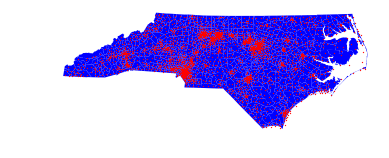

In [14]:
ax = tr_rn.plot(color = "blue")
geo_votes_2012.set_geometry(geo_votes_2012.centroid).plot(color = "red", markersize = 1, ax = ax)
ax.set_axis_off()

In [15]:
votes12 = merge_tract_number(tr_rn, geo_votes_2012)[["D12", "R12"]]
votes16 = merge_tract_number(tr_rn, geo_votes_2016)[["D16", "R16"]]

In [16]:
nc_votes = votes12.join(votes16, how = "outer").fillna(0).astype(float).groupby("rn").sum()
nc_votes.to_csv("votes/nc.csv")

In [19]:
pd.read_csv("votes/nc.csv").head()

,rn,D12,R12,D16,R16
0,0,1444.0,1072.0,1494.0,943.0
1,1,594.0,344.0,552.0,322.0
2,2,987.0,570.0,996.0,528.0
3,3,2009.0,275.0,1777.0,289.0
4,5,1982.0,596.0,1831.0,637.0
